# Classification: Instant Recognition with Caffe

## 1. Setup

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

import sys
caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe

In [2]:
import os
if os.path.isfile(caffe_root + 'models/bvlc_googlenet/bvlc_googlenet.caffemodel'):
    print 'GoogleNet found.'
else:
    print 'Downloading pre-trained GoogleNet model...'
    !../scripts/download_model_binary.py ../models/bvlc_googlenet

GoogleNet found.


## 2. Load net and set up input preprocessing

In [3]:
caffe.set_mode_cpu()

model_def = caffe_root + 'models/bvlc_googlenet/deploy.prototxt'
model_weights = caffe_root + 'models/bvlc_googlenet/bvlc_googlenet.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [4]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


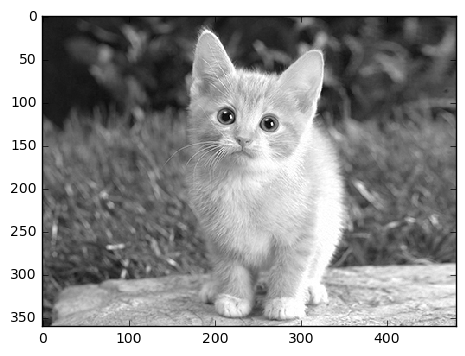

In [5]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(5,        # batch size
                          3,         # 3-channel (BGR) images
                          224, 224)  # image size is 224x224

image = caffe.io.load_image(caffe_root + 'examples/images/cat gray.jpg')
#transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

In [6]:
#Crop images into the four corners, center, and their mirrored versions. 
#pay attention to images and image
images=np.empty((1,360,480,3),dtype=np.float32)
images[0]=image

#default crop_size=(224,224),the same as the input size of googlenet
crop_image=caffe.io.oversample(images,(224,224))

## 3. CPU classification

In [7]:
#intialize transformed_image
transformed_image=np.zeros((5,3,224,224))

for ix in range(5):
    transformed_image[ix] = transformer.preprocess('data', crop_image[ix])

# copy the image data into the memory allocated for the net
# set the batch size as 5 with crop images of the four corners, center versions. 

net.blobs['data'].data[...] =transformed_image

### perform classification
output = net.forward()
output_prob = output['prob'][:5].mean(0)  # the output probability vector for the first image in the batch
      

print 'predicted class is:', output_prob.argmax()

predicted class is: 283


In [8]:
# load ImageNet labels
labels_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
if not os.path.exists(labels_file):
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    
labels = np.loadtxt(labels_file, str, delimiter='\t')

print 'output label:', labels[output_prob.argmax()]

output label: n02123394 Persian cat


In [9]:
# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]  # reverse sort and take five largest items

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

probabilities and labels:


[(0.19049326, 'n02123394 Persian cat'),
 (0.12259804, 'n02120079 Arctic fox, white fox, Alopex lagopus'),
 (0.117175, 'n02124075 Egyptian cat'),
 (0.041990772, 'n02326432 hare'),
 (0.037079521, 'n04589890 window screen')]